# Random Forests and Titanic dataset

Welcome to this week`s session. We will implement Random Forests and use it to predict the survival of titanic passengers.

The RandomForest implementation is based on fastai`s machine learning course (see http://course18.fast.ai/lessonsml1/lesson7.html for the lecture and for the code: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson3-rf_foundations.ipynb ). The license for the RandomForest code can be found at: https://github.com/fastai/fastai/blob/master/LICENSE

In [1]:
!pip install seaborn --upgrade 
!pip install matplotlib --upgrade

import time
import pandas as pd
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import graphviz 

ERROR: Exception:
Traceback (most recent call last):
  File "c:\program files\python38\lib\site-packages\pip\_internal\cli\base_command.py", line 186, in _main
    status = self.run(options, args)
  File "c:\program files\python38\lib\site-packages\pip\_internal\commands\install.py", line 253, in run
    options.use_user_site = decide_user_install(
  File "c:\program files\python38\lib\site-packages\pip\_internal\commands\install.py", line 604, in decide_user_install
    if site_packages_writable(root=root_path, isolated=isolated_mode):
  File "c:\program files\python38\lib\site-packages\pip\_internal\commands\install.py", line 548, in site_packages_writable
    return all(
  File "c:\program files\python38\lib\site-packages\pip\_internal\commands\install.py", line 549, in <genexpr>
    test_writable_dir(d) for d in set(get_lib_location_guesses(**kwargs))
  File "c:\program files\python38\lib\site-packages\pip\_internal\utils\filesystem.py", line 140, in test_writable_dir
    return _t

## Revisiting the Titanic dataset 
Loading the Titanic dataset which you are already acquainted with.

In [2]:
sns.set()
titanic = sns.load_dataset("titanic")
titanic = titanic.dropna(subset=["embarked", "embark_town"])
print(titanic.describe())

         survived      pclass         age       sibsp       parch        fare
count  889.000000  889.000000  712.000000  889.000000  889.000000  889.000000
mean     0.382452    2.311586   29.642093    0.524184    0.382452   32.096681
std      0.486260    0.834700   14.492933    1.103705    0.806761   49.697504
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.000000    0.000000    0.000000    7.895800
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


In [3]:
sex = pd.get_dummies(titanic["sex"], drop_first=True)
fare = titanic["fare"]
parch = titanic["parch"]
pclass = titanic["pclass"]
sibsp = titanic["sibsp"]

x = pd.concat([sex, fare, parch, pclass, sibsp], axis=1)
y = titanic["survived"].values
labels = ['not survived', 'survived']

In contrast to some other exercises where we converted our tabular data to Numpy matrices, this is not necessary here. Instead we can use Pandas' data frame directly and index the needed data with the "iloc" function. 

In [4]:
perm = np.random.permutation(len(x))

split = 0.8

x_train, x_test = x.iloc[perm[:int(split*len(x))]], x.iloc[perm[int(split*len(x)):]]
y_train, y_test = y[perm[:int(split*len(y))]], y[perm[int(split*len(y)):]]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(711, 5) (178, 5) (711,) (178,)


Define a function to compute the accuracy of the prediction.

In [5]:
# this accuracy calculation will work only for 2 classes (!)
def accuracy(pred, y_target):
    threshold = 0.5
    y_target = y_target.squeeze()
    pred=pred.squeeze()
    
    # where boolean prediction mask and target match, there will be a 1, else 0
    return ((pred>=threshold)*y_target+(pred < threshold)*(1-y_target)).sum()/float(len(y_target))

## Introduction to sklearn`s **RandomForestClassifier** and **RandomForestRegressor**
First, we will classify, which Titanic passengers survived, using the RandomForestClassifier. Then, RandomForestRegressor will be used for the same task to exemplify that the **splitting metric**, as well as **leaf values** (classes vs. numbers) differs, but in principle the way the tree is grown stays the same.

In [6]:
# define the RandomForestClassifier and fit the data (build 1 tree with max depth 2 and set the bootstrap parameter to False)
# when bootstrap is set to false, all the data are fed to every classifier
m = RandomForestClassifier(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=2, n_estimators=1)

In [7]:
# predict the results for your train and test data
preds_train = m.predict(x_train)
preds_test = m.predict(x_test)

# calculate the accuracy
acc_train = accuracy(preds_train, y_train)
acc_test = accuracy(preds_test, y_test)

# print the results
print('train_acc: {0:4f}, test_acc: {1:4f}'.format(acc_train, acc_test))

train_acc: 0.791842, test_acc: 0.764045


**Graphviz ** is an open source graph visualization software: 
https://www.graphviz.org/, 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

711 435.0 276.0 290.0 229.0 61.0
gini_root: 0.474995, gini_left: 0.332200


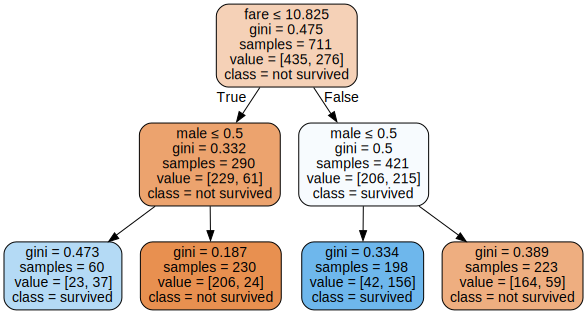

In [8]:
# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0],
                                out_file=None, 
                                feature_names=x_train.columns,  
                                class_names=labels,
                                filled=True,
                                rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data) 

t = m.estimators_[0].tree_

n_samples = len(y_train)

# the first zero indicates the first node, 
# the second can be ignored, the third one is the non-survived/survived value
n_samples_ns = t.value[0][0][0] # number of not survived after first split
n_samples_s = t.value[0][0][1] # number of survived after first split

n_samples_left_ns = t.value[1][0][0]
n_samples_left_s = t.value[1][0][1]

n_samples_left = n_samples_left_ns + n_samples_left_s

# compare the values with the graph below
print(n_samples,n_samples_ns,n_samples_s,n_samples_left,n_samples_left_ns,n_samples_left_s)

# compute the gini impurity for the root node and its left child
gini_root = 1. - (n_samples_ns/n_samples)**2 - (n_samples_s/n_samples)**2 #TODO
gini_left = 1. - (n_samples_left_ns/n_samples_left)**2 - (n_samples_left_s/n_samples_left)**2 #TODO

print('gini_root: {0:2f}, gini_left: {1:3f}'.format(gini_root, gini_left))

graph

Let us change the splitting criterion from **Gini** to **Information Gain**.

train_acc: 0.679325, test_acc: 0.646067
root_entropy:0.963619, left_entropy:0.991076, right_entropy:0.808192
gain: 0.072087, intrinsic_information: 0.994329, gain_ratio: 0.072498


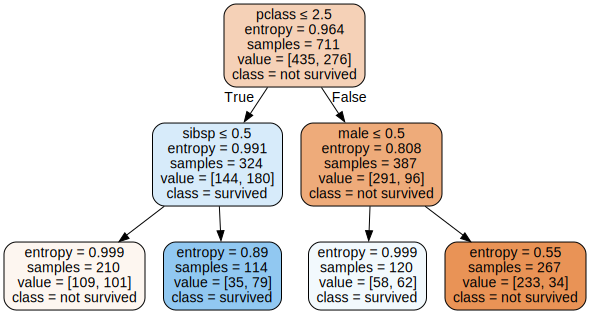

In [10]:
# define the RandomForestClassifier with entropy as the splitting criterion, 1 tree, max_depth=2 and bootstrap=False
# and fit the data
m = RandomForestClassifier(n_estimators=1, criterion="entropy", max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

# predict the results for your train and test data
preds_train = m.predict(x_train)
preds_test = m.predict(x_test)

# calculate the accuracy
acc_train = accuracy(preds_train, y_train)
acc_test = accuracy(preds_test, y_test)

# print the results
print('train_acc: {0:4f}, test_acc: {1:4f}'.format(acc_train, acc_test))

# prepare the variables for the entropy gain calculation
t = m.estimators_[0].tree_
n_samples = float(len(y_train))

n_samples_ns = t.value[0][0][0] # number of not survived before first split
n_samples_s = t.value[0][0][1] # number of survived before first split

n_samples_lns = t.value[1][0][0] # number of not survived after first split for the first node
n_samples_ls = t.value[1][0][1]

n_samples_left = float(n_samples_lns + n_samples_ls)

# to get the root right nodes directly, use children_right
n_samples_rns = t.value[t.children_right][0][0][0]
n_samples_rs = t.value[t.children_right][0][0][1]

n_samples_right = float(n_samples_rns + n_samples_rs)

# calculate the entropy gain

entropy_root = //TODO

entropy_left = //TODO
entropy_right = //TODO

print('root_entropy:{0:4f}, left_entropy:{1:4f}, right_entropy:{2:4f}'.format(entropy_root, entropy_left, entropy_right))

gain = entropy_root - (n_samples_left/n_samples)*entropy_left - (n_samples_right/n_samples)*entropy_right
intrinsic_information = -(n_samples_left/n_samples)*np.log2(n_samples_left/n_samples)-(n_samples_right/n_samples)*np.log2(n_samples_right/n_samples)
gain_ratio = gain/intrinsic_information

print('gain: {0:2f}, intrinsic_information: {1:3f}, gain_ratio: {2:3f}'.format(gain, intrinsic_information, gain_ratio))

# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

Let us repeat the same process we went through for the **RandomForestClassifier**, for the **RandomForestRegressor**: 

1. define the regressor
2. fit the data
3. calculate the accuracy
4. visualize the tree graph for the first tree




In [11]:
# define the RandomForestRegressor and fit the data
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=2, n_estimators=1)

In [12]:
# predict the results for your train and test data
preds_train = m.predict(x_train)
preds_test = m.predict(x_test)

# calculate the accuracy

acc_train = accuracy(preds_train, y_train)
acc_test = accuracy(preds_test, y_test)

# print the results
print('train_acc: {0:4f}, test_acc: {1:4f}'.format(acc_train, acc_test))

train_acc: 0.791842, test_acc: 0.764045


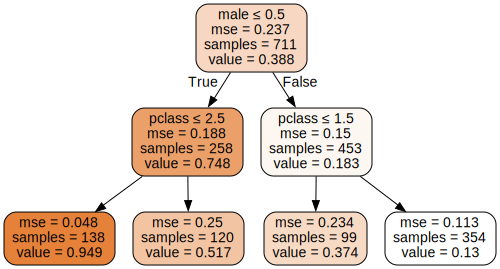

In [13]:
# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

## RandomForest from scratch. 

What we need are 2 classes:

1. TreeEnsemble class which combines trees.
2. DecisionTree class which grows single trees given subsets of data.

In [15]:
# the TreeEnsemble class is adapted from fastai (the seed has been taken out, comments added, 
# sample_sz, min_leaf variable name changed, added max_depth parameter
class TreeEnsemble():
    """
    A class that builds n estimators (decision trees) and averages their prediction.
    """
    
    def __init__(self, x, y, n_trees, n_samples, min_sample_leaf=5, max_depth=2):
        """
        Initialize the TreeEnsemble
        
        Args:
          x (pandas DataFrame): input data of dimensions (num_instances, num_features)
          y (array of targets): numbers for regression or categories for classification
          n_trees (int): number of decision trees to create
          n_samples (int): number of data samples to use for each tree
          min_sample_leaf (int): minimal number of data instances, in order to split the node
        """
        
        self.x = x
        self.y = y
        self.n_samples = n_samples 
        self.min_sample_leaf = min_sample_leaf
        self.max_depth = max_depth
        
        # create n_trees amout of trees and save them in a list
        self.trees = //TODO

    def create_tree(self):
        # create the indices of data instances to take: 1. permute data indices, 2. take first n_samples
        idxs = np.random.permutation(len(self.y))[:self.n_samples]
        
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], idxs=np.array(range(self.n_samples)), 
                            min_sample_leaf=self.min_sample_leaf, max_depth=self.max_depth)
    
    def predict(self, x):
        """
        This function calculates the mean prediction over the list of decision trees

        Args:
          x (pandas DataFrame): input data of dimensions (num_instances, num_features)

        Returns:
          array of floats of length num_instances: the mean prediction over decision trees for each data instance
        """
        
        # given that DecisionTree class also has a predict(x) function, calculate the mean prediction for all trees
        # hint: the data (x) has dimensions (num_examples, num_features), so the mean has to be calculated over a specific axis
        return //TODO

Test the TreeEnsemble class with dummy data (only a basic test that the class does not throw errors upon definition)

In [16]:
# create a dummy DecisionTree class
class DecisionTree():
    def __init__(self, x, y, idxs, min_sample_leaf=5, max_depth=2):
        pass
    
    def predict(self, x):
      # dummy output
      return [1., 2., 3.]

In [17]:
# test the TreeEnsemble class: the dummy output of DecisionTree suggests 3 data instances, 
# thus, ens.predict should return the same (think why - how do you calculate the mean?)
ens = TreeEnsemble(x_train, y_train, n_trees=5, n_samples=int(0.5*len(x_train)))

if not sum(ens.predict(x_train)) == 6:
    raise ValueError("The tree ensemble implementation does not seem to be correct")

Let us now create the **DecisionTree** class.

In [18]:
# the DecisionTree class is adapted from fastai 
# (comments added, variable name (min_leaf) changed, find_varsplit and find_better_split changed)
class DecisionTree():
    def __init__(self, x, y, idxs, min_sample_leaf=5, max_depth=5, curr_depth=0):
        """
        Initialize the DecisionTree
        
        Args:
          x (pandas DataFrame): input data of dimensions (num_instances, num_features)
          y (array of targets): numbers for regression or categories for classification
          indxs (array): indices of data instances which belong to this node of the decision tree
          min_sample_leaf (int): minimal number of data instances, in order to split the node
          max_depth (int): maximum depth of the tree
          curr_depth (int): depth of the given node (0 for root, 1 for its children etc.)
        """
        
        self.x = x
        self.y = y
        self.idxs = idxs
        self.min_sample_leaf = min_sample_leaf
        
        # n - number of data instances in the tree/node, c - number of features
        self.n,self.c = len(idxs), x.shape[1]
        
        # the predicted class or regressed value for the leaf
        self.val = float(np.mean(y[idxs]))
        # the criterion (entropy, mse) value at this node
        # it is not identical to the score, 
        # as the score is the weighting of the criterions of node and children
        self.criterion_val = self.split_criterion(y[idxs])
        
        # the splitting score given the splitting criterion
        self.score = float('inf')
        self.var_idx = None # index of the feature/variable to split on
        self.split = None # the split value
        
        self.max_depth = max_depth
        self.depth = curr_depth
                
        if self.depth < self.max_depth: self.find_varsplit()
        
    def find_varsplit(self):
        # for each feature, check whether it provides the best split
        # set the var_idx, score and split value
        for i in range(self.c): 
            curr_score = self.binary_split(i)
            
        # the criteria for splitting the node are not met - it will be a leaf
        if self.score == float('inf'): return
        
        # get the values of the column along which the split is about to be done
        x = self.split_col
        # get the indices of the data instances to the left and right
        # numpy.nonzero returns a tuple of arrays, one for each dimension, row-major, C-style
        lhs = //TODO
        rhs = //TODO
        
        # create the left and right decision trees, 
        # pay attentio to select from self.idxs only the correct one
        # hint: use lhs and rhs above
        self.lhs = DecisionTree(self.x, self.y, //TODO, max_depth=self.max_depth, curr_depth=self.depth+1)
        self.rhs = DecisionTree(self.x, self.y, //TODO, max_depth=self.max_depth, curr_depth=self.depth+1)

    def binary_split(self, var_idx):
        # get the column of all x values for a certain feature
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

        # go through all data instances and check whether to split on that value
        for i in range(self.n):
            # calculate boolean masks which split the feature along a certain value
            lhs = //TODO
            rhs = //TODO
            
            # check that both right and left node children have at least min_samples_leaf data instances
            # if not - the score will stay infinity, so the node will remain unsplitted
            if rhs.sum()<self.min_sample_leaf or lhs.sum()<self.min_sample_leaf: continue
            curr_score = self.split_score(lhs, rhs, y)
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

    def split_score(self, lhs, rhs, y):
        '''
        This function calculates the weighted score for the split.
        
        Args:
          lhs (array of booleans): the mask for which instances would split to the left
          rhs (array of booleans): the mask for which instances would split to the right
          y (array of numbers): the class or value to predict
        
        '''
        
        lhs_var = self.split_criterion(y[lhs])
        rhs_var = self.split_criterion(y[rhs])
        
        # weighted (by the number of examples right and left) variance
        curr_score = lhs_var*lhs.sum() + rhs_var*rhs.sum()
        return curr_score
      
    def split_criterion(self, y):
        # mean squared error is the splitting criterion for regression
        # hint: how do mse and variance relate to each other?
        return //TODO
    
    # a property decorator means that you can omit brackets when you call this function
    # for example in __repr__ self.split_name
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = "n: {0}; val:{1:4f}; mse/entropy/gini:{2:4f}; depth:{3}".format(self.n, self.val, self.criterion_val, self.depth) 
        
        if not self.is_leaf:
            s += "; score:{0:4f}; split:{1}; var:{2}".format(self.score,self.split,self.split_name)
        return s

    def predict(self, x):
        # for each data instance (a row of features), make a prediction 
        return //TODO

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        # check if the feature values for the feature we are splitting on
        # are smaller or bigger than the split value
        # if smaller/equal - assign left tree to t, else right tree
        
        t = //TODO
        return t.predict_row(xi)

In [19]:
ens = TreeEnsemble(x_train, y_train, 1, len(y_train), max_depth=2)
print(ens.trees[0])
print(ens.trees[0].lhs)
print(ens.trees[0].lhs.lhs)
print(ens.trees[0].lhs.rhs)
print(ens.trees[0].rhs)

n: 711; val:0.388186; mse/entropy/gini:0.237498; depth:0; score:116.416525; split:0.0; var:male
n: 258; val:0.748062; mse/entropy/gini:0.188465; depth:1; score:36.611594; split:2.0; var:pclass
n: 138; val:0.949275; mse/entropy/gini:0.048152; depth:2
n: 120; val:0.516667; mse/entropy/gini:0.249722; depth:2
n: 453; val:0.183223; mse/entropy/gini:0.149652; depth:1; score:63.194316; split:1.0; var:pclass


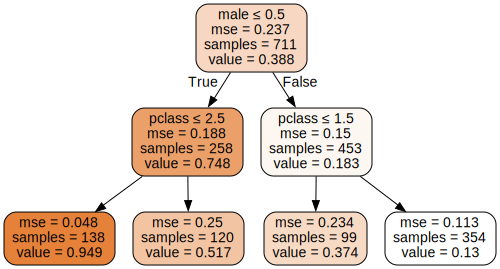

In [20]:
# compare the calculated regressed values to the random forest

m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

Exchange the splitting criterion of the DecisionTree from **mse** to** entropy**, create sklearn's **RandomForestClassifier** and compare the entropies

In [21]:
def split_criterion(self, y):
    entropy = 0
    eps = 1e-15
    # yi is the class value, e.g. 0,1,2 if there are 3 classes, 0, 1 in our case
    for yi in np.unique(y):
        //TODO
    return entropy

In [22]:
# exchange the earlier split_criterion function (mse) with the one above
DecisionTree.split_criterion=split_criterion

In [23]:
ens = TreeEnsemble(x_train, y_train, 1, len(y_train), max_depth=2)
print(ens.trees[0])
print(ens.trees[0].lhs)
print(ens.trees[0].lhs.lhs)
print(ens.trees[0].lhs.rhs)
print(ens.trees[0].rhs)

n: 711; val:0.388186; mse/entropy/gini:0.963619; depth:0; score:521.344462; split:0.0; var:male
n: 258; val:0.748062; mse/entropy/gini:0.814335; depth:1; score:159.850280; split:2.0; var:pclass
n: 138; val:0.949275; mse/entropy/gini:0.289467; depth:2
n: 120; val:0.516667; mse/entropy/gini:0.999198; depth:2
n: 453; val:0.183223; mse/entropy/gini:0.687077; depth:1; score:291.674620; split:1.0; var:pclass


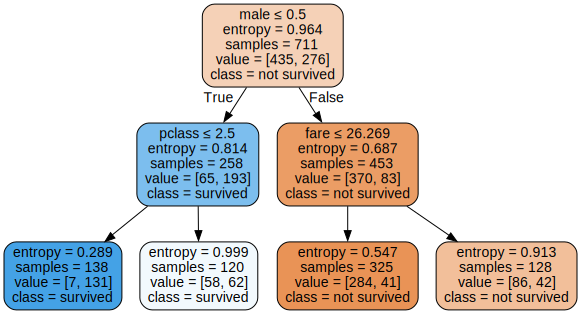

In [24]:
# since RandomForestClassifier selects randomly m best features to split on, we fix the seed
# the random split on a subset of features serves the aim of reducing overfitting (variance) of the model
# for more on bias-variance trade-off check ou:
# https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229
# if the split is still long different variables than above, then comment the next line out and run the cell a couple of times...
np.random.seed(1936483610)

m = RandomForestClassifier(n_estimators=1, criterion='entropy', max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 

graph